In [1]:
import requests
from bs4 import BeautifulSoup

In [35]:
def fetch(query = None, auto_make_model = None, min_auto_year = None, max_auto_year = None, s=0):
    search_params = {key: val for key, val in locals().items() if val is not None}
    if not search_params: 
        raise ValueError("No valid keywords")
        
    base = "http://boston.craigslist.org/search/cto"
    resp = requests.get(base, params=search_params, timeout=3)
    resp.raise_for_status()
    return resp.content, resp.encoding

In [4]:
def parse(html, encoding='utf-8'):
    parsed = BeautifulSoup(html, from_encoding=encoding)
    return parsed

In [33]:
def extract_listings(parsed):
    listings = parsed.find_all('p', class_='result-info')
    extracted = []
    for listing in listings:
        title = listing.find('a', class_='result-title hdrlnk')
        price = listing.find('span', class_='result-price')
        try:
            price_string = price.string.strip()
        except AttributeError:
            price = ''
        location = listing.find('span', class_='result-hood')
        try:
            loc_string = location.string.strip()[1:-1].split()[0]
        except AttributeError:
            loc_string = ''
        this_listing = {
            'link': title.attrs['href'],
            'description': title.string.strip(),
            'price': price_string,
            'location': loc_string
        }
        extracted.append(this_listing)
    return extracted

In [36]:
listings = []
for i in range(0, 500, 100):
    car_results = fetch(auto_make_model="honda civic", min_auto_year=2000, max_auto_year=2016, s=i)
    doc = parse(car_results[0])
    listings.extend(extract_listings(doc))

In [212]:
print len(listings)

498


In [17]:
print doc.prettify()

<!DOCTYPE html>
<html class="no-js">
 <head>
  <title>
   boston cars &amp; trucks - by owner  - craigslist
  </title>
  <meta content="boston cars &amp; trucks - by owner  - craigslist" name="description"/>
  <meta content="IE=Edge" http-equiv="X-UA-Compatible"/>
  <link href="https://boston.craigslist.org/search/cto" rel="canonical"/>
  <link href="https://boston.craigslist.org/search/cto?auto_make_model=honda%20civic&amp;format=rss&amp;max_auto_year=2016&amp;min_auto_year=2000" rel="alternate" title="RSS feed for craigslist | boston cars &amp; trucks - by owner  - craigslist " type="application/rss+xml"/>
  <link href="https://boston.craigslist.org/search/cto?s=100&amp;auto_make_model=honda%20civic&amp;max_auto_year=2016&amp;min_auto_year=2000" rel="next"/>
  <meta content="width=device-width,initial-scale=1" name="viewport"/>
  <link href="//www.craigslist.org/styles/cl.css?v=dc354a481b75e5f3dda81340da9d1f6c" media="all" rel="stylesheet" type="text/css"/>
  <link href="//www.craigs

In [430]:
import pandas as pd
import numpy as np

In [457]:
df = pd.DataFrame(data=listings)

In [444]:
import re

def get_mileage(description):
    description = description.lower().split('k miles')
    if len(description) == 1:
        description = description[0].split('000 miles')
        if len(description) == 1:
            try:
                description = re.search('(\d{1,3})k', description[0]).groups()
            except:
                return np.nan
    mileage = re.sub('[^0-9]', '', description[0].split()[-1])
    try:
        mileage = int(mileage) * 1000
        return mileage
    except:
        return np.nan

In [458]:
df['mileage'] = df.apply(lambda row: get_mileage(row['description']), axis=1)
df

,description,link,location,price,mileage
0,Honda Civic,/gbs/cto/5989776771.html,,$4200,NaN
1,2007 Honda Civic EX 44k miles Navigation,/gbs/cto/5989687842.html,,$6000,44000
2,STOCK* 03 Honda Civic LX Coupe *ONLY 82K MILES...,/nos/cto/5961022154.html,Peabody,$4000,82000
3,2001 Honda Civic ex 4 door,/nos/cto/5981791146.html,"Methuen,ma",$1000,NaN
4,2009 Honda Civic,/nwb/cto/5971263468.html,,$5500,NaN
5,2001 Honda Civic EX Coupe,/sob/cto/5989542888.html,Brockton,$2995,NaN
6,"2003 HONDA CIVIC, HYBRID !",/gbs/cto/5989536810.html,ROSLINDALE,$3200,NaN
7,2007 HONDA CIVIC HYBRID with NAVI AND BATTERY...,/gbs/cto/5989449656.html,"Pelham,nh",$6250,NaN
8,2007 honda civic,/gbs/cto/5989445526.html,Nashua/Manchester/Salem,$4500,NaN
9,2005 honda civic,/gbs/cto/5989361447.html,Nashua/Manchester/Salem,$4500,NaN


In [469]:
def get_year(description):
    description = re.split('(20[0-9][0-9])', description)
    if len(description) == 1:
        description = re.split('([0-1][0-9])', description[0])
    try:
        return int(description[1]) if len(description[1]) == 4 else int('20' + description[1])
    except:
        return np.nan

In [470]:
df['year'] = df.apply(lambda row: get_year(row['description']), axis=1)
df

,description,link,location,price,mileage,year
0,Honda Civic,/gbs/cto/5989776771.html,,$4200,NaN,NaN
1,2007 Honda Civic EX 44k miles Navigation,/gbs/cto/5989687842.html,,$6000,44000,2007
2,STOCK* 03 Honda Civic LX Coupe *ONLY 82K MILES...,/nos/cto/5961022154.html,Peabody,$4000,82000,2003
3,2001 Honda Civic ex 4 door,/nos/cto/5981791146.html,"Methuen,ma",$1000,NaN,2001
4,2009 Honda Civic,/nwb/cto/5971263468.html,,$5500,NaN,2009
5,2001 Honda Civic EX Coupe,/sob/cto/5989542888.html,Brockton,$2995,NaN,2001
6,"2003 HONDA CIVIC, HYBRID !",/gbs/cto/5989536810.html,ROSLINDALE,$3200,NaN,2003
7,2007 HONDA CIVIC HYBRID with NAVI AND BATTERY...,/gbs/cto/5989449656.html,"Pelham,nh",$6250,NaN,2007
8,2007 honda civic,/gbs/cto/5989445526.html,Nashua/Manchester/Salem,$4500,NaN,2007
9,2005 honda civic,/gbs/cto/5989361447.html,Nashua/Manchester/Salem,$4500,NaN,2005


In [499]:
def get_standard_location(location):
    """
    Use first 5 characters of location in order to group. Gets rid of much of the weird stuff
    """
    if len(location) < 5:
        return location.lower()
    else:
        return location[:5].lower()

df['std_location'] = df.apply(lambda row: get_standard_location(row['location']), axis=1)
df['region'] = df['link'].str[1:4]
df

,description,link,location,price,mileage,year,region,std_location
0,Honda Civic,/gbs/cto/5989776771.html,,4200,NaN,NaN,gbs,
1,2007 Honda Civic EX 44k miles Navigation,/gbs/cto/5989687842.html,,6000,44000,2007,gbs,
2,STOCK* 03 Honda Civic LX Coupe *ONLY 82K MILES...,/nos/cto/5961022154.html,Peabody,4000,82000,2003,nos,peabo
3,2001 Honda Civic ex 4 door,/nos/cto/5981791146.html,"Methuen,ma",1000,NaN,2001,nos,methu
4,2009 Honda Civic,/nwb/cto/5971263468.html,,5500,NaN,2009,nwb,
5,2001 Honda Civic EX Coupe,/sob/cto/5989542888.html,Brockton,2995,NaN,2001,sob,brock
6,"2003 HONDA CIVIC, HYBRID !",/gbs/cto/5989536810.html,ROSLINDALE,3200,NaN,2003,gbs,rosli
7,2007 HONDA CIVIC HYBRID with NAVI AND BATTERY...,/gbs/cto/5989449656.html,"Pelham,nh",6250,NaN,2007,gbs,pelha
8,2007 honda civic,/gbs/cto/5989445526.html,Nashua/Manchester/Salem,4500,NaN,2007,gbs,nashu
9,2005 honda civic,/gbs/cto/5989361447.html,Nashua/Manchester/Salem,4500,NaN,2005,gbs,nashu


In [551]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [473]:
df['price'] = df['price'].str[1:].astype(int)
df

,description,link,location,price,mileage,year,region
0,Honda Civic,/gbs/cto/5989776771.html,,4200,NaN,NaN,gbs
1,2007 Honda Civic EX 44k miles Navigation,/gbs/cto/5989687842.html,,6000,44000,2007,gbs
2,STOCK* 03 Honda Civic LX Coupe *ONLY 82K MILES...,/nos/cto/5961022154.html,Peabody,4000,82000,2003,nos
3,2001 Honda Civic ex 4 door,/nos/cto/5981791146.html,"Methuen,ma",1000,NaN,2001,nos
4,2009 Honda Civic,/nwb/cto/5971263468.html,,5500,NaN,2009,nwb
5,2001 Honda Civic EX Coupe,/sob/cto/5989542888.html,Brockton,2995,NaN,2001,sob
6,"2003 HONDA CIVIC, HYBRID !",/gbs/cto/5989536810.html,ROSLINDALE,3200,NaN,2003,gbs
7,2007 HONDA CIVIC HYBRID with NAVI AND BATTERY...,/gbs/cto/5989449656.html,"Pelham,nh",6250,NaN,2007,gbs
8,2007 honda civic,/gbs/cto/5989445526.html,Nashua/Manchester/Salem,4500,NaN,2007,gbs
9,2005 honda civic,/gbs/cto/5989361447.html,Nashua/Manchester/Salem,4500,NaN,2005,gbs


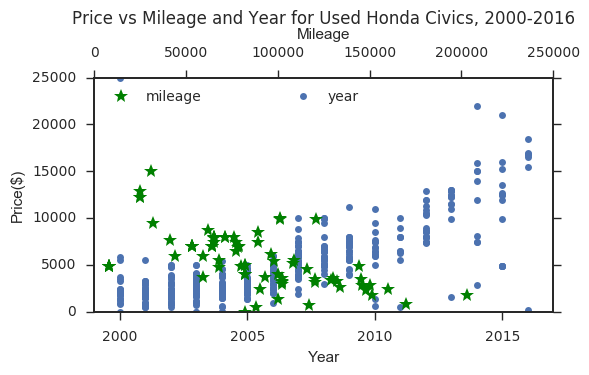

In [573]:
sns.set_style("ticks")
fig = plt.figure(figsize=(6,4))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Year')
ax1.set_ylabel('Price($)')
ax1.set_title('Price vs Mileage and Year for Used Honda Civics, 2000-2016', y= 1.2)
plt.plot(df['year'], df['price'], '.', ms=10, label='year')
ax1.set_xbound(lower=1999, upper=2017)
ax1.legend(loc='best')
ax2 = ax1.twiny()
ax2.set_xlabel('Mileage')
plt.plot(df['mileage'], df['price'], 'g*', ms=10, label='mileage')
ax2.legend(loc=2)
plt.tight_layout()
plt.savefig('price_year_mileage.pdf')

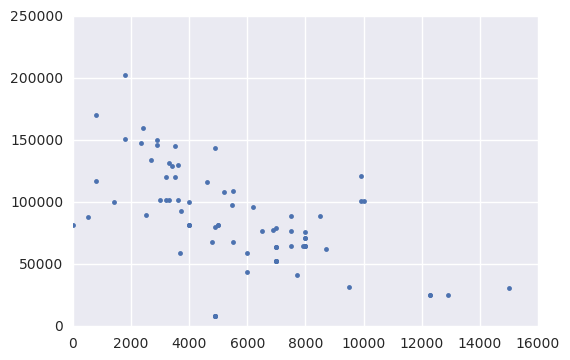

In [475]:
plt.plot(df['price'], df['mileage'], linestyle='', marker='.')

In [574]:
regions = df.groupby('region').mean()

In [575]:
print df.groupby('region').count()

        description  link  location  price  mileage  year  std_location
region                                                                 
bmw              26    26        26     26        4    23            26
gbs             302   302       302    302       48   275           302
nos              71    71        71     71       13    67            71
nwb              42    42        42     42        8    41            42
sob              57    57        57     57        6    52            57


In [576]:
regions = regions.append(pd.Series(data={'year': np.mean(df['year']), 'price': np.mean(df['price']), 'mileage': np.mean(df['mileage'])}, name='AVERAGE'))

In [577]:
regions

,price,mileage,year
region,,,
bmw,5968.923077,74500.000000,2008.000000
gbs,4947.764901,96541.666667,2006.058182
nos,3815.436620,84692.307692,2005.044776
nwb,6017.000000,18625.000000,2008.414634
sob,4799.894737,81000.000000,2005.769231
AVERAGE,4912.893574,84405.063291,2006.185590


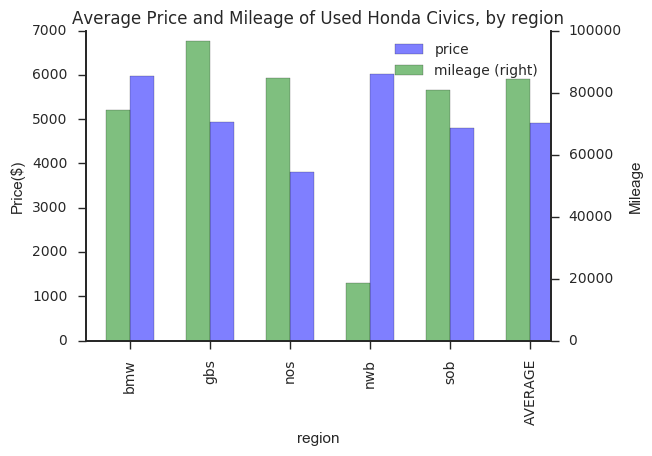

In [611]:
ax = regions['price'].plot.bar(position=0, width=0.3, alpha=0.5, legend=True, title='Average Price and Mileage of Used Honda Civics, by region')
ax.set_ylabel('Price($)')
ax = regions['mileage'].plot.bar(secondary_y=True, color='green', position=1, width=0.3, alpha=0.5, legend=True)
ax.set_ylabel('Mileage')
sns.despine(top=True, right=False)
fig=ax.get_figure()
fig.savefig('price_mileage_region.pdf', bbox_inches='tight')

In [506]:
from scipy.stats import linregress

In [508]:
print linregress(df['mileage'][~df['price'].isnull()].dropna(), df['price'][~df['mileage'].isnull()].dropna())
print linregress(df['year'][~df['price'].isnull()].dropna(), df['price'][~df['year'].isnull()].dropna())
print linregress(df['year'][~df['mileage'].isnull()].dropna(), df['mileage'][~df['year'].isnull()].dropna())

LinregressResult(slope=-0.040652479906192085, intercept=9062.1105824618844, rvalue=-0.56351277891090501, pvalue=6.4131409880625065e-08, stderr=0.0067916359184524702)
LinregressResult(slope=678.39787761222567, intercept=-1356024.3735372799, rvalue=0.75118710842333314, pvalue=2.7200712052538879e-84, stderr=27.916222301096791)
LinregressResult(slope=-5596.2466042024707, intercept=11317347.092088481, rvalue=-0.57558724134561456, pvalue=2.8713348990505597e-08, stderr=906.05751299103667)
